Target support ys shape: (9, 2)
Computing Kantorovich potential φ...
[OT dual] iter   200/2000, F ≈ 0.6009
[OT dual] iter   400/2000, F ≈ 0.6492
[OT dual] iter   600/2000, F ≈ 0.6566
[OT dual] iter   800/2000, F ≈ 0.6725
[OT dual] iter  1000/2000, F ≈ 0.6515
[OT dual] iter  1200/2000, F ≈ 0.6712
[OT dual] iter  1400/2000, F ≈ 0.6847
[OT dual] iter  1600/2000, F ≈ 0.6556
[OT dual] iter  1800/2000, F ≈ 0.6618
[OT dual] iter  2000/2000, F ≈ 0.6514
Done-> φ shape: (9,)


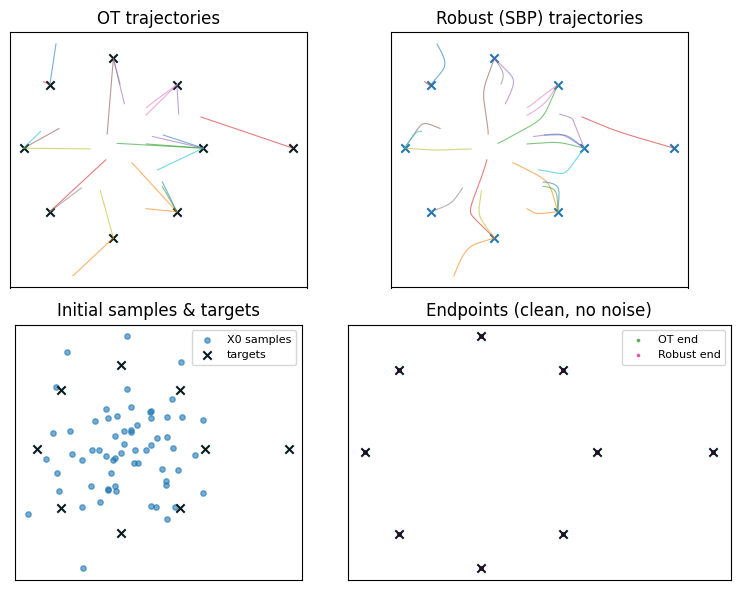

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from data_gen import *
# ============================================================
# Main experiment: OT vs robust flows + endpoint sensitivity
# ============================================================
from utils import *

rng = np.random.default_rng(0)
# Experiment parameters
n_modes = 8
radius = 2.0
dim = 2
n_samples = 4096          # how many trajectories we simulate
n_steps = 1000            # ODE steps
n_iters_ot = 2000         # OT dual iterations for φ
batch_size_ot = 2048
lr_ot = 0.1
eps_smooth = 0.8          # ε for smoothed Hopf–Lax
# sigma_list = [0, 0.5, 1]
sigma_list = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

target_color = ['#081B1F']
ot_color = ['#017C01']
sbp_color = ['#C5036F']
initial_samples_color = ['#606C6C']


# 1) Build semi-discrete target
ys = make_circle_plus_outlier(n_modes=8, radius=2.0, outlier_dist=4)

N = ys.shape[0]
nu = np.ones(N) / N      # start uniform
nu[-1] = 0.05        # give the outlier small mass
nu[:-1] = (1.0 - nu[-1]) / (N - 1)   # re-normalize the rest

print("Target support ys shape:", ys.shape)

# 2) Approximate Kantorovich potential φ (semi-discrete OT dual)
print("Computing Kantorovich potential φ...")
phi = compute_kantorovich_potential(
    ys, 
    nu=nu,
    n_iters=n_iters_ot,
    batch_size=batch_size_ot,
    lr=lr_ot,
    seed=0,
    verbose=True,
)
phi_clean = phi.copy()
print("Done-> φ shape:", phi_clean.shape)

# 3) Clean OT and robust drifts
def v_ot_clean(x, t, phi_clean=phi_clean):
    return velocity_ot(x, t, phi_clean, ys)

def v_rob_clean(x, t, phi_clean=phi_clean):
    return velocity_robust(x, t, phi_clean, ys, eps_smooth=eps_smooth)

# 4) Sample a fixed set of initial points X0 (same for all σ)
x0_fixed = sample_base(n_samples, dim, rng)

# 5) Compute clean endpoints (no potential noise)
xT_ot_clean = simulate_ode(v_ot_clean, x0_fixed, n_steps=n_steps)
xT_rob_clean = simulate_ode(v_rob_clean, x0_fixed, n_steps=n_steps)

# Additionally, we compute some clean trajectories for visualization
n_traj = 64
x0_traj = sample_base(n_traj, dim, rng)
path_ot = simulate_ode_path(v_ot_clean, x0_traj, n_steps=500)
path_rob = simulate_ode_path(v_rob_clean, x0_traj, n_steps=500)

# 6) Plot clean trajectories
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax00, ax01, ax10, ax11 = axes.flatten()

idx_plot = np.arange(min(25, n_traj))

for i in idx_plot:
    ax00.plot(path_ot[:, i, 0], path_ot[:, i, 1], linewidth=0.8, alpha=0.6)
ax00.scatter(ys[:, 0], ys[:, 1], marker="x", c=target_color)
ax00.set_title("OT trajectories")
ax00.set_aspect("equal")
ax00.set_xticks([]); ax00.set_yticks([])

for i in idx_plot:
    ax01.plot(path_rob[:, i, 0], path_rob[:, i, 1], linewidth=0.8, alpha=0.6)
ax01.scatter(ys[:, 0], ys[:, 1], marker="x")
ax01.set_title("Robust (SBP) trajectories")
ax01.set_aspect("equal")
ax01.set_xticks([]); ax01.set_yticks([])

ax10.scatter(x0_traj[:, 0], x0_traj[:, 1], s=15, alpha=0.6, label="X0 samples")
ax10.scatter(ys[:, 0], ys[:, 1], marker="x", label="targets", c=target_color)
ax10.set_title("Initial samples & targets")
ax10.set_aspect("equal")
ax10.set_xticks([]); ax10.set_yticks([])
ax10.legend(loc="upper right", fontsize=8)

ax11.scatter(xT_ot_clean[:, 0], xT_ot_clean[:, 1], s=3, alpha=0.5, label="OT end", c=ot_color)
ax11.scatter(xT_rob_clean[:, 0], xT_rob_clean[:, 1], s=3, alpha=0.5, label="Robust end", c=sbp_color)
ax11.scatter(ys[:, 0], ys[:, 1], marker="x", c=target_color)
ax11.set_title("Endpoints (clean, no noise)")
ax11.set_aspect("equal")
ax11.set_xticks([]); ax11.set_yticks([])
ax11.legend(loc="upper right", fontsize=8)

fig.tight_layout()
plt.show()



=== Time = 0.000 ===

=== Time = 0.111 ===

=== Time = 0.222 ===

=== Time = 0.333 ===

=== Time = 0.444 ===

=== Time = 0.556 ===

=== Time = 0.667 ===

=== Time = 0.778 ===

=== Time = 0.889 ===

=== Time = 1.000 ===


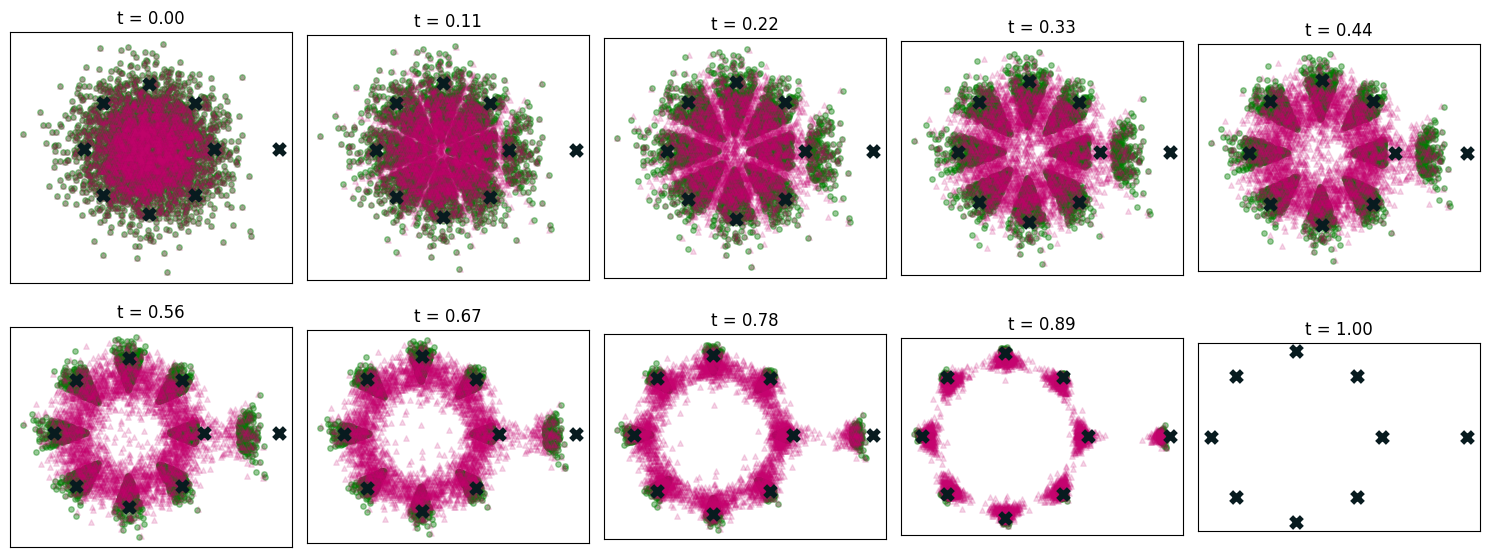

In [7]:
# ============================================================
# 10 time-slice plots for OT vs SBP under maximum noise level
# ============================================================
sigma_max = sigma_list[0]
phi_tilde = phi_clean + rng.normal(scale=sigma_max, size=phi_clean.shape)

def v_ot_max(x, t, phi_tilde=phi_tilde):
    return velocity_ot(x, t, phi_tilde, ys)

def v_rob_max(x, t, phi_tilde=phi_tilde):
    return velocity_robust(x, t, phi_tilde, ys, eps_smooth=eps_smooth)

# Choose 10 evenly spaced times
time_points = np.linspace(0.0, 1.0, 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for idx, t_visual in enumerate(time_points):
    # print(idx)
    print(f"\n=== Time = {t_visual:.3f} ===")

    # simulate from t=0 to t=t_visual
    xT_ot  = simulate_ode(v_ot_max,  x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)
    xT_rob = simulate_ode(v_rob_max, x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)

    ax = axes[idx]
    ax.scatter(
        xT_ot[:, 0], xT_ot[:, 1],
        s=15, marker="o", alpha=0.4, label="OT", c=ot_color 
    )
    ax.scatter(
        xT_rob[:, 0], xT_rob[:, 1],
        s=15, marker="^", alpha=0.15, label="SBP", c=sbp_color
    )
    ax.scatter(
        ys[:, 0], ys[:, 1],
        s=60, marker="x", linewidths=4, c=['#081B1F']
    )

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"t = {t_visual:.2f}")

plt.tight_layout()
plt.show()
fig.savefig("trajectories_circle.pdf", format="pdf", bbox_inches="tight")

In [8]:
# ============================================================
# Main experiment: OT vs robust flows + endpoint sensitivity
# with 10 repetitions and averaged robustness plot
# ============================================================
def run_single_sensitivity_experiment(seed):
    """
    Run the whole OT vs robust endpoint sensitivity experiment once,
    with a given random seed.

    Returns:
        sens_ot  shape [len(sigma_list)]
        sens_rob shape [len(sigma_list)]
    """
    rng = np.random.default_rng(seed)

    # 2) Approximate Kantorovich potential φ (semi discrete OT dual)
    print(f"\n=== Computing Kantorovich potential with seed = {seed} ===")
    phi = compute_kantorovich_potential(
        ys,
        n_iters=n_iters_ot,
        batch_size=batch_size_ot,
        lr=lr_ot,
        seed=seed,        # important: tie OT dual randomness to this seed
        verbose=False,
    )
    phi_clean = phi.copy()

    # 3) Clean OT and robust drifts
    def v_ot_clean(x, t, phi_clean=phi_clean):
        return velocity_ot(x, t, phi_clean, ys)

    def v_rob_clean(x, t, phi_clean=phi_clean):
        return velocity_robust(x, t, phi_clean, ys, eps_smooth=eps_smooth)

    # 4) Sample a fixed set of initial points X0 for this run
    x0_fixed = sample_base(n_samples, dim, rng)

    # 5) Compute clean endpoints (no potential noise)
    xT_ot_clean = simulate_ode(v_ot_clean, x0_fixed, n_steps=n_steps)
    xT_rob_clean = simulate_ode(v_rob_clean, x0_fixed, n_steps=n_steps)

    # 6) Robustness experiment: endpoint sensitivity vs σ for this run
    sens_ot_run = []
    sens_rob_run = []

    for sigma in sigma_list:
        print(f"  [seed {seed}] sigma = {sigma:.3f}")
        # noise on φ
        phi_tilde = phi_clean + rng.normal(scale=sigma, size=phi_clean.shape)

        def v_ot_noisy(x, t, phi_tilde=phi_tilde):
            return velocity_ot(x, t, phi_tilde, ys)

        def v_rob_noisy(x, t, phi_tilde=phi_tilde):
            return velocity_robust(x, t, phi_tilde, ys, eps_smooth=eps_smooth)

        # propagate the same X0 under noisy φ
        xT_ot_noisy = simulate_ode(v_ot_noisy,  x0_fixed, n_steps=n_steps)
        xT_rob_noisy = simulate_ode(v_rob_noisy, x0_fixed, n_steps=n_steps)

        # sensitivity = mean squared displacement from clean endpoints
        err_ot = endpoint_sensitivity(xT_ot_clean,  xT_ot_noisy)
        err_rob = endpoint_sensitivity(xT_rob_clean, xT_rob_noisy)
        sens_ot_run.append(err_ot)
        sens_rob_run.append(err_rob)

    sens_ot_run = np.array(sens_ot_run, dtype=np.float64)
    sens_rob_run = np.array(sens_rob_run, dtype=np.float64)
    return sens_ot_run, sens_rob_run

# ============================================================
# Repeat experiment 10 times with different seeds
# ============================================================
n_runs = 10
base_seed = 0

all_sens_ot = []
all_sens_rob = []

for run_idx in range(n_runs):
    seed = base_seed + run_idx
    sens_ot_run, sens_rob_run = run_single_sensitivity_experiment(seed)
    all_sens_ot.append(sens_ot_run)
    all_sens_rob.append(sens_rob_run)

all_sens_ot = np.stack(all_sens_ot, axis=0)   # shape [n_runs, len(sigma_list)]
all_sens_rob = np.stack(all_sens_rob, axis=0)

# ============================================================
# Compute mean and std across runs
# ============================================================

mean_sens_ot = all_sens_ot.mean(axis=0)
std_sens_ot  = all_sens_ot.std(axis=0, ddof=1)

mean_sens_rob = all_sens_rob.mean(axis=0)
std_sens_rob  = all_sens_rob.std(axis=0, ddof=1)






=== Computing Kantorovich potential with seed = 0 ===
  [seed 0] sigma = 0.000
  [seed 0] sigma = 0.050
  [seed 0] sigma = 0.100
  [seed 0] sigma = 0.200
  [seed 0] sigma = 0.300
  [seed 0] sigma = 0.400
  [seed 0] sigma = 0.500
  [seed 0] sigma = 0.600
  [seed 0] sigma = 0.700
  [seed 0] sigma = 0.800
  [seed 0] sigma = 0.900
  [seed 0] sigma = 1.000

=== Computing Kantorovich potential with seed = 1 ===
  [seed 1] sigma = 0.000
  [seed 1] sigma = 0.050
  [seed 1] sigma = 0.100
  [seed 1] sigma = 0.200
  [seed 1] sigma = 0.300
  [seed 1] sigma = 0.400
  [seed 1] sigma = 0.500
  [seed 1] sigma = 0.600
  [seed 1] sigma = 0.700
  [seed 1] sigma = 0.800
  [seed 1] sigma = 0.900
  [seed 1] sigma = 1.000

=== Computing Kantorovich potential with seed = 2 ===
  [seed 2] sigma = 0.000
  [seed 2] sigma = 0.050
  [seed 2] sigma = 0.100
  [seed 2] sigma = 0.200
  [seed 2] sigma = 0.300
  [seed 2] sigma = 0.400
  [seed 2] sigma = 0.500
  [seed 2] sigma = 0.600
  [seed 2] sigma = 0.700
  [seed 2]

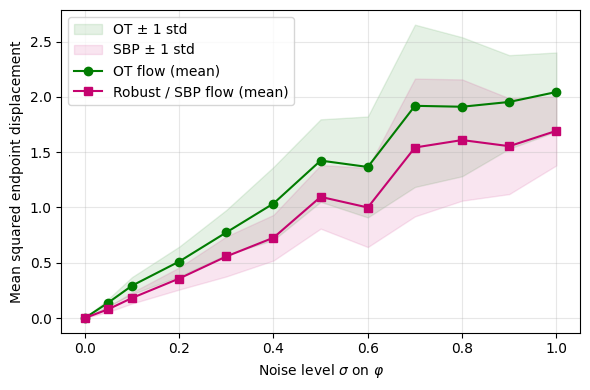

In [10]:
# ============================================================
# Plot averaged sensitivity with ±band_factor std band
# ============================================================
band_factor = 1
fig, ax = plt.subplots(figsize=(6, 4))

sigma_array = np.array(sigma_list, dtype=np.float64)
ax.fill_between(
    sigma_array,
    mean_sens_ot  - band_factor * std_sens_ot,
    mean_sens_ot  + band_factor * std_sens_ot,
    alpha=0.1,
    linewidth=1,
    label=f"OT ± {band_factor} std",
    color=ot_color[0],
    edgecolor=ot_color[0]
)

ax.fill_between(
    sigma_array,
    mean_sens_rob - band_factor * std_sens_rob,
    mean_sens_rob + band_factor * std_sens_rob,
    alpha=0.1,
    linewidth=1,
    label=f"SBP ± {band_factor} std",
    color=sbp_color[0],
    edgecolor=sbp_color[0]
)
ax.plot(sigma_array, mean_sens_ot,  marker="o", label="OT flow (mean)", c=ot_color[0])
ax.plot(sigma_array, mean_sens_rob, marker="s", label="Robust / SBP flow (mean)", c=sbp_color[0])

ax.set_xlabel(r"Noise level $\sigma$ on $\varphi$")
ax.set_ylabel(r"Mean squared endpoint displacement")
# ax.set_title(f"Endpoint sensitivity vs potential noise averaged over {n_runs} runs")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig.savefig("sensitivity_noisy_ring.pdf", format="pdf", bbox_inches="tight")


In [11]:
# # displacement from clean endpoints at the same time t_visual

# t_visual = 1.0
# xT_ot_clean_vis  = simulate_ode(v_ot_clean,  x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)
# xT_rob_clean_vis = simulate_ode(v_rob_clean, x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)

# disp_ot  = np.linalg.norm(xT_ot_max  - xT_ot_clean_vis, axis=1)
# disp_sbp = np.linalg.norm(xT_rob_max - xT_rob_clean_vis, axis=1)

# plt.figure(figsize=(5, 3))
# plt.legend(['OT displacement', 'SBP displacement'])

# plt.hist([disp_ot, disp_sbp], stacked=True, bins=40,color=[ot_color[0], sbp_color[0]], edgecolor='black', label=['OT displacment', 'SBP displacement'])

# plt.xlabel(r"$\|X_T^{\mathrm{noisy}} - X_T^{\mathrm{clean}}\|$")
# plt.ylabel("count")


# plt.title(f"Endpoint displacement at t={t_visual}, σ={sigma_max}")
# plt.legend()
# plt.tight_layout()
# plt.show()
